In [1]:
from __future__ import annotations
import torch
from torch import Tensor
import random
import math
from typing import List, Tuple, Union, Iterable, Callable, Optional
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

## Config

In [32]:
State = Tensor # vehicle, vuln, feature
StateBatch = Tensor
DefenderAction = Tensor # vehicles
DefenderActionBatch = Tensor
AttackerAction = Tensor # vehicles
AttackerActionBatch = Tensor
Reward = Tensor
RewardBatch = Tensor
Terminal = Tensor
TerminalBatch = Tensor

MAX_VEHICLES                        = 10     #@param {type:"integer"}
MAX_VULNS                           = 3      #@param {type:"integer"}
MAX_ATTACK                          = 2      #@param {type:"integer"}

BATCH_SIZE                          = 1000    #@param {type:"integer"}
MEMORY_SIZE                         = 10000  #@param {type:"integer"}
MEMORY_WARMUP_STEPS                 = 2000     #@param {type:"integer"} # scaled by batch size

TRAIN_STEPS                         = 25     #@param {type:"integer"}
EXPLORATION_STEPS_PER_TRAIN_STEP    = 1      #@param {type:"integer"} # scaled by batch size

LEARNING_RATE                       = 0.001  #@param {type:"number"}
LEARNING_RATE_GAMMA                 = 0.9    #@param {type:"number"}
LEARNING_RATE_GAMMA_FREQUENCY       = 100    #@param {type:"integer"}

REWARD_GAMMA                        = 0.99   #@param {type:"number"}

EPSILON_DECAY_STEPS                 = 10000  #@param {type:"integer"}
EPSILON_THETA                       = 0.0    #@param {type:"number"}
EPSILON_MU                          = 0.0    #@param {type:"number"}
EPSILON_SIGMA                       = 3      #@param {type:"number"}

SOFT_UPDATE_TAU                     = 0.001  #@param {type:"number"}

EVAL_STEPS                          = 100    #@param {type:"integer"}

DEVICE = torch.cuda.is_available() and torch.device('cuda') or torch.device('cpu')

## Definitions

### States

#### get random starting state

In [33]:
def get_random_starting_state() -> State:
    prob_dist = torch.distributions.Normal(
        loc=torch.as_tensor(0.5, dtype=torch.float32),
        scale=torch.as_tensor(0.25, dtype=torch.float32),
    )
    sev_dist = torch.distributions.Normal(
        loc=torch.as_tensor(2, dtype=torch.float32),
        scale=torch.as_tensor(1, dtype=torch.float32),
    )
    state = torch.zeros((MAX_VEHICLES, MAX_VULNS, 4), dtype=torch.float32)
    for i in range(MAX_VEHICLES):
        for j in range(random.randint(0, MAX_VULNS)):
            state[i,j,0] = float(prob_dist.sample().clamp(0.05,1)) # prob
            state[i,j,1] = int(sev_dist.sample().clamp(1,5)) ** 2 # sev
            state[i,j,2] = 0 # compromised
            state[i,j,3] = 0 # membership

    return state

#### get empty state

In [34]:
def get_empty_state() -> State:
    return torch.zeros((MAX_VEHICLES, MAX_VULNS, 4), dtype=torch.float32)

#### batch states

In [35]:
def batch_states(states: Union[Tuple[State, ...], List[State]]) -> StateBatch:
    return torch.stack(states)

#### get random starting state batch

In [36]:
def get_random_starting_state_batch(num_batches: int) -> StateBatch:
    return batch_states([get_random_starting_state() for _ in range(num_batches)])

### Actions

#### get attacker actions

In [37]:
def get_attacker_actions(states: StateBatch) -> AttackerActionBatch:
    priority = (states[:,:,:,0] * states[:,:,:,1] * (1-states[:,:,:,2])).sum(dim=-1)
    # find indices of vehicles to attack
    attack = priority.topk(MAX_ATTACK).indices
    # return mask of vehicles to attack
    return torch.zeros((states.shape[0], MAX_VEHICLES), dtype=torch.float32).to(states.device).scatter_(1, attack, 1)

#### apply attacker actions

In [38]:
def apply_attacker_actions(states: StateBatch, actions: AttackerActionBatch) -> StateBatch:
    assert states.shape[0] == actions.shape[0]
    assert states.device == actions.device

    # create a copy so we don't modify the original
    states = states.clone()

    # roll probability for each vulnerability
    probs = torch.rand((states.shape[0], MAX_VEHICLES, MAX_VULNS), dtype=torch.float32, device=states.device)

    # only keep vulns for vehicles that are being attacked
    for i in range(states.shape[0]):
        probs[i, actions[i]!=1, :] = 0 

    # set the vulnerability compromised flag to 1 for each successful attack
    states[:,:,:,2] += (probs > 1-states[:,:,:,0]).float()
    states[:,:,:,2] = states[:,:,:,2].clamp(0, 1)
    return states

#### get exploring defender actions

In [39]:
def get_exploring_defender_actions(states: StateBatch) -> DefenderActionBatch:
    assert states.shape[0] > MAX_VEHICLES * 2 # we want to give diagonal and random actions a chance

    diag = torch.eye(MAX_VEHICLES, dtype=torch.float32, device=states.device)
    rand = (torch.rand((states.shape[0] - MAX_VEHICLES, MAX_VEHICLES), dtype=torch.float32, device=states.device) > 0.5).float()
    return torch.cat((diag, rand))

#### apply defender actions

In [40]:
def apply_defender_actions(states: StateBatch, actions: DefenderActionBatch) -> StateBatch:
    assert states.shape[0] == actions.shape[0]
    assert states.device == actions.device

    # create a copy so we don't modify the original
    states = states.clone()

    # set the membership flag to 1 for each vuln in each vehicle that is chosen
    states[:,:,:,3] = 0
    for i in range(states.shape[0]):
        states[i,actions[i,:]==1,:,3] = 1
    return states

### Rewards

#### get defender utilities

In [41]:
def get_defender_utilities(states: StateBatch) -> RewardBatch:
    # identify which platoons contain compromised vehicles
    compromise_free_platoons = (states[:,:,:,2] * states[:,:,:,3]).sum(dim=[-1,-2]) == 0
    # identify size of each platoon
    members = states[:,:,:,3].max(dim=-1).values.sum(dim=-1)
    # return 0 if platoon is compromised, size of platoon otherwise
    return members * compromise_free_platoons.float()

### Modelling

In [42]:
import torch.nn as nn
import torch.nn.functional as F

#### Actor

In [43]:
class DefenderActor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.LazyConv2d(out_channels=5, kernel_size=2, stride=1)
        self.fc1 = nn.LazyLinear(256)
        self.fc2 = nn.LazyLinear(128)
        self.fc3 = nn.LazyLinear(MAX_VEHICLES)

    def forward(self, x: StateBatch) -> DefenderActionBatch:
        x = torch.hstack((
            F.gelu(self.conv1(x)).flatten(start_dim=1),
            x.flatten(start_dim=1), # skip connection after conv
        ))
        x = F.gelu(self.fc1(x))
        x = F.gelu(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        return x

#### Critic

In [44]:
class DefenderCritic(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.LazyConv2d(out_channels=5, kernel_size=2, stride=1)
        self.fc1 = nn.LazyLinear(256)
        self.fc2 = nn.LazyLinear(128)
        self.fc3 = nn.LazyLinear(1)
    def forward(self, x1: StateBatch, x2: DefenderActionBatch) -> Reward:
        x = torch.hstack((
            F.gelu(self.conv1(x1)).flatten(start_dim=1),
            x1.flatten(start_dim=1), # skip connection after conv
            x2,
        ))
        x = F.gelu(self.fc1(x))
        x = F.gelu(self.fc2(x))
        x = self.fc3(x)
        return x

#### Replay memory

In [45]:
from collections import deque
from dataclasses import dataclass

@dataclass
class Transition:
    state: State
    action: DefenderAction
    reward: Reward
    next_state: State
    terminal: Terminal

    def to(self, device: torch.device) -> 'Transition':
        return Transition(
            state=self.state.to(device),
            action=self.action.to(device),
            reward=self.reward.to(device),
            next_state=self.next_state.to(device),
            terminal=self.terminal.to(device),
        )

@dataclass
class TransitionBatch:
    states: StateBatch
    actions: DefenderActionBatch
    rewards: RewardBatch
    next_states: StateBatch
    terminals: TerminalBatch

    
    def to(self, device: torch.device) -> 'TransitionBatch':
        return TransitionBatch(
            states=self.states.to(device),
            actions=self.actions.to(device),
            rewards=self.rewards.to(device),
            next_states=self.next_states.to(device),
            terminals=self.terminals.to(device),
        )

In [46]:
def sample_memory(memory: deque, batch_size: int) -> TransitionBatch:
    samples = random.sample(memory, batch_size)
    return TransitionBatch(
        states=torch.stack([s.state for s in samples]),
        actions=torch.stack([s.action for s in samples]),
        rewards=torch.stack([s.reward for s in samples]),
        next_states=torch.stack([s.next_state for s in samples]),
        terminals=torch.stack([s.terminal for s in samples]),
    )

In [47]:
# from https://github.com/ghliu/pytorch-ddpg/blob/master/util.py#L26

def soft_update(target, source, tau):
        for target_param, param in zip(target.parameters(), source.parameters()):
            ## shouldn't be necessary since we use target networks to calculate loss
            # if isinstance(target_param, torch.nn.parameter.UninitializedParameter):
            #     # target model uninitialize, hard update
            #     target_param.data.copy_(param.data)
            # else:
            target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)

def hard_update(target, source):
    for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(param.data)
# from original deepRL author code
class RandomProcess(object):
    def reset_states(self):
        pass
class AnnealedGaussianProcess(RandomProcess):
    def __init__(self, mu, sigma, sigma_min, n_steps_annealing):
        self.mu = mu
        self.sigma = sigma
        self.n_steps = 0

        if sigma_min is not None:
            self.m = -float(sigma - sigma_min) / float(n_steps_annealing)
            self.c = sigma
            self.sigma_min = sigma_min
        else:
            self.m = 0.
            self.c = sigma
            self.sigma_min = sigma

    @property
    def current_sigma(self):
        sigma = max(self.sigma_min, self.m * float(self.n_steps) + self.c)
        return sigma

# Based on http://math.stackexchange.com/questions/1287634/implementing-ornstein-uhlenbeck-in-matlab
class OrnsteinUhlenbeckProcess(AnnealedGaussianProcess):
    def __init__(self, theta, mu=0., sigma=1., dt=1e-2, x0=None, size=1, sigma_min=None, n_steps_annealing=1000):
        super(OrnsteinUhlenbeckProcess, self).__init__(mu=mu, sigma=sigma, sigma_min=sigma_min, n_steps_annealing=n_steps_annealing)
        self.theta = theta
        self.mu = mu
        self.dt = dt
        self.x0 = x0
        self.size = size
        self.normal = torch.distributions.Normal(torch.as_tensor(0, dtype=torch.float32), torch.as_tensor(1, dtype=torch.float32))
        self.reset_states()

    def sample(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + self.current_sigma * torch.sqrt(torch.as_tensor(self.dt, dtype=torch.float32)) * self.normal.sample((self.size,))  # type: ignore
        self.x_prev = x
        self.n_steps += 1
        return x

    def reset_states(self):
        self.x_prev = self.x0 if self.x0 is not None else torch.zeros(self.size)

### Learning and exploration

In [48]:
# from https://github.com/ghliu/pytorch-ddpg/blob/master/util.py#L26

def soft_update(target, source, tau):
        for target_param, param in zip(target.parameters(), source.parameters()):
            ## shouldn't be necessary since we use target networks to calculate loss
            # if isinstance(target_param, torch.nn.parameter.UninitializedParameter):
            #     # target model uninitialize, hard update
            #     target_param.data.copy_(param.data)
            # else:
            target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)

def hard_update(target, source):
    for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(param.data)

In [49]:
# from original deepRL author code
class RandomProcess(object):
    def reset_states(self):
        pass
class AnnealedGaussianProcess(RandomProcess):
    def __init__(self, mu, sigma, sigma_min, n_steps_annealing):
        self.mu = mu
        self.sigma = sigma
        self.n_steps = 0

        if sigma_min is not None:
            self.m = -float(sigma - sigma_min) / float(n_steps_annealing)
            self.c = sigma
            self.sigma_min = sigma_min
        else:
            self.m = 0.
            self.c = sigma
            self.sigma_min = sigma

    @property
    def current_sigma(self):
        sigma = max(self.sigma_min, self.m * float(self.n_steps) + self.c)
        return sigma

# Based on http://math.stackexchange.com/questions/1287634/implementing-ornstein-uhlenbeck-in-matlab
class OrnsteinUhlenbeckProcess(AnnealedGaussianProcess):
    def __init__(self, theta, mu=0., sigma=1., dt=1e-2, x0=None, size=1, sigma_min=None, n_steps_annealing=1000):
        super(OrnsteinUhlenbeckProcess, self).__init__(mu=mu, sigma=sigma, sigma_min=sigma_min, n_steps_annealing=n_steps_annealing)
        self.theta = theta
        self.mu = mu
        self.dt = dt
        self.x0 = x0
        self.size = size
        self.normal = torch.distributions.Normal(torch.as_tensor(0, dtype=torch.float32), torch.as_tensor(1, dtype=torch.float32))
        self.reset_states()

    def sample(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + self.current_sigma * torch.sqrt(torch.as_tensor(self.dt, dtype=torch.float32)) * self.normal.sample((self.size,))  # type: ignore
        self.x_prev = x
        self.n_steps += 1
        return x

    def reset_states(self):
        self.x_prev = self.x0 if self.x0 is not None else torch.zeros(self.size)

## Training

### Init

In [50]:
# memory: deque[Transition] = deque(maxlen=MEMORY_SIZE) # colab uses old python version that doesn't support this :P
memory = deque(maxlen=MEMORY_SIZE)

In [51]:
actor = DefenderActor().to(DEVICE)
actor_target = DefenderActor().to(DEVICE)
critic = DefenderCritic().to(DEVICE)
critic_target = DefenderCritic().to(DEVICE)

c:\Users\TeamD\.conda\envs\subgame\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [52]:
# ensure weights are initialized
states = get_random_starting_state_batch(1).to(DEVICE)
critic(states, actor(states))
critic_target(states, actor_target(states))

# hard update weights
hard_update(actor_target, actor)
hard_update(critic_target, critic)

In [53]:
actor_optimizer = torch.optim.Adam(actor.parameters(), lr=LEARNING_RATE)
actor_scheduler = torch.optim.lr_scheduler.StepLR(
    actor_optimizer,
    step_size=LEARNING_RATE_GAMMA_FREQUENCY,
    gamma=LEARNING_RATE_GAMMA,
)
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=LEARNING_RATE)
critic_scheduler = torch.optim.lr_scheduler.StepLR(
    critic_optimizer,
    step_size=LEARNING_RATE_GAMMA_FREQUENCY,
    gamma=LEARNING_RATE_GAMMA,
)

In [54]:
epsilon = 1.0
epsilon_decay = epsilon / EPSILON_DECAY_STEPS
epsilon_noise = OrnsteinUhlenbeckProcess(
    size=MAX_VEHICLES,
    theta=EPSILON_SIGMA,
    mu=EPSILON_MU,
    sigma=EPSILON_SIGMA,
)

criterion = nn.MSELoss()

digits = math.ceil(math.log10(TRAIN_STEPS))

### Warmup

#### Random games

In [55]:
states = get_random_starting_state_batch(BATCH_SIZE).to(DEVICE)

# perform random exploration for one set of state sequences
for _ in tqdm(range(MEMORY_WARMUP_STEPS // 4)):
    # random exploration
    defender_actions = get_exploring_defender_actions(states)
    next_states = apply_defender_actions(states, defender_actions)
    attacker_actions = get_attacker_actions(next_states)
    next_states = apply_attacker_actions(next_states, attacker_actions)
    rewards = get_defender_utilities(next_states)
    terminals = rewards == 0

    # track next states as empty if terminal
    next_states[terminals] = get_empty_state()

    # save each transition in the batch to memory
    for i in range(BATCH_SIZE):
        memory.append(Transition(
            state=states[i],
            action=defender_actions[i],
            reward=rewards[i],
            next_state=next_states[i],
            terminal=torch.as_tensor(rewards[i] == 0),
        ))

    # reset environment for terminal states
    states = next_states.clone()
    states[terminals] = get_random_starting_state_batch(int(terminals.sum()))

  0%|          | 0/500 [00:00<?, ?it/s]

#### Alternate paths

In [ ]:
# using random states from the memory, see what would happen if we took different actions at those states
for _ in tqdm(range(MEMORY_WARMUP_STEPS // 4 * 3)):
    states = sample_memory(memory, BATCH_SIZE).states

    # random exploration
    defender_actions = get_exploring_defender_actions(states)
    next_states = apply_defender_actions(states, defender_actions)
    attacker_actions = get_attacker_actions(next_states)
    next_states = apply_attacker_actions(next_states, attacker_actions)
    rewards = get_defender_utilities(next_states)
    terminals = rewards == 0

    # track next states as empty if terminal
    next_states[terminals] = get_empty_state()

    # save each transition in the batch to memory
    for i in range(BATCH_SIZE):
        memory.append(Transition(
            state=states[i],
            action=defender_actions[i],
            reward=rewards[i],
            next_state=next_states[i],
            terminal=torch.as_tensor(rewards[i] == 0),
        ))

    # reset environment for terminal states
    states = next_states.clone()
    states[terminals] = get_random_starting_state_batch(int(terminals.sum()))

  0%|          | 0/15 [00:00<?, ?it/s]

### Preflight checks

(array([648.,  93.,  29.,  56.,   0.,  67.,  54.,  38.,  13.,   2.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

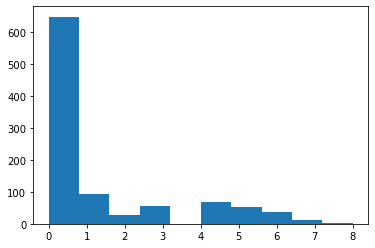

In [ ]:
plt.hist(sample_memory(memory, 1000).rewards.numpy())

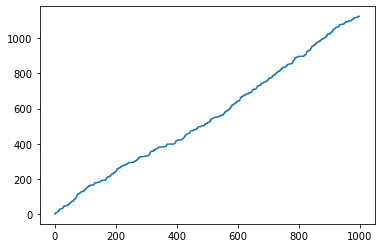

In [ ]:
plt.plot(sample_memory(memory, 1000).rewards.cumsum(0).numpy())

### Train loop

In [ ]:
critic_loss_history = []
actor_loss_history = []

In [ ]:
states = get_random_starting_state_batch(BATCH_SIZE).to(DEVICE)

In [ ]:
for i in tqdm(range(TRAIN_STEPS)):
    print(f"train step {i:0{digits}d}", end=" ")
    # epsilon-noise exploration
    print(f"exploring", end=" ")
    for j in range(EXPLORATION_STEPS_PER_TRAIN_STEP):
        proto_defender_actions = actor(states)
        for i in range(BATCH_SIZE):
            proto_defender_actions[i] += epsilon * epsilon_noise.sample().to(proto_defender_actions.device)
        epsilon = max(0.0, epsilon - epsilon_decay)
        defender_actions: DefenderActionBatch = (proto_defender_actions > 0.5).float() # convert to binary
        next_states = apply_defender_actions(states, defender_actions)
        attacker_actions = get_attacker_actions(next_states)
        next_states = apply_attacker_actions(next_states, attacker_actions)
        rewards = get_defender_utilities(next_states)
        terminals = rewards == 0

        # track next states as empty if terminal
        next_states[terminals] = get_empty_state().to(DEVICE)
        
        # save each transition in the batch to memory
        for i in range(BATCH_SIZE):
            memory.append(Transition(
                state=states[i],
                action=defender_actions[i],
                reward=rewards[i],
                next_state=next_states[i],
                terminal=torch.as_tensor(rewards[i] == 0, dtype=torch.bool),
            ).to(torch.device("cpu")))

        # reset environment for terminal states
        states = next_states.clone()
        states[terminals] = get_random_starting_state_batch(int(terminals.sum())).to(DEVICE)

    # train
    print(f"optimizing", end=" ")
    batch = sample_memory(memory, BATCH_SIZE).to(DEVICE)

    with torch.no_grad():
        q_next: Tensor = critic_target(
            batch.next_states,
            actor_target(batch.next_states),
        )
    q_next.requires_grad_()
    q_target = q_next * REWARD_GAMMA * (1-batch.terminals.float().unsqueeze(1)) + batch.rewards.unsqueeze(1)

    critic.zero_grad()
    q_pred = critic(batch.states, batch.actions)
    critic_loss = criterion(q_pred, q_target)
    critic_loss.backward()
    critic_optimizer.step()
    critic_scheduler.step()
    print(f"critic loss: {critic_loss.item():.4f}", end=" ")
    critic_loss_history.append(critic_loss.item())

    actor.zero_grad()
    actor_loss = -critic(batch.states, actor(batch.states)).mean()
    actor_loss.backward()
    actor_optimizer.step()
    actor_scheduler.step()
    print(f"actor loss: {actor_loss.item():.4f}", end=" ")
    actor_loss_history.append(actor_loss.item())

    soft_update(actor_target, actor, SOFT_UPDATE_TAU)
    soft_update(critic_target, critic, SOFT_UPDATE_TAU)


    print()

  0%|          | 0/25 [00:00<?, ?it/s]

train step 00 exploring optimizing critic loss: 6.2893 actor loss: -0.3094 
train step 01 exploring optimizing critic loss: 5.0385 actor loss: -0.5422 
train step 02 exploring optimizing critic loss: 4.9382 actor loss: -0.8416 
train step 03 exploring optimizing critic loss: 4.1262 actor loss: -1.1511 
train step 04 exploring optimizing critic loss: 3.8404 actor loss: -1.3261 
train step 05 exploring optimizing critic loss: 4.3313 actor loss: -1.4203 
train step 06 exploring optimizing critic loss: 4.3813 actor loss: -1.4826 
train step 07 exploring optimizing critic loss: 3.5567 actor loss: -1.4466 
train step 08 exploring optimizing critic loss: 4.3499 actor loss: -1.3340 
train step 09 exploring optimizing critic loss: 3.2199 actor loss: -1.2237 
train step 10 exploring optimizing critic loss: 3.9822 actor loss: -1.2135 
train step 11 exploring optimizing critic loss: 4.5845 actor loss: -1.1157 
train step 12 exploring optimizing critic loss: 5.7925 actor loss: -1.1533 
train step 1

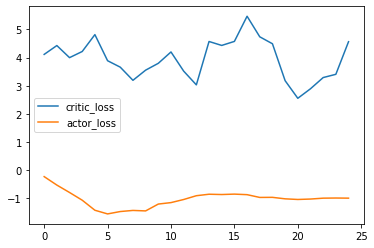

In [ ]:
plt.plot(critic_loss_history, label="critic_loss")
plt.plot(actor_loss_history, label="actor_loss")
plt.legend()

## Eval

In [ ]:
eval_rewards = []

In [ ]:
states = get_random_starting_state_batch(BATCH_SIZE).to(DEVICE)

for _ in tqdm(range(EVAL_STEPS)):
    proto_defender_actions = actor(states)
    defender_actions: DefenderActionBatch = (proto_defender_actions > 0.5).float() # convert to binary
    next_states = apply_defender_actions(states, defender_actions)
    attacker_actions = get_attacker_actions(next_states)
    next_states = apply_attacker_actions(next_states, attacker_actions)
    rewards = get_defender_utilities(next_states)
    terminals = rewards == 0

    # track next states as empty if terminal
    next_states[terminals] = get_empty_state().to(DEVICE)

    eval_rewards.append(rewards)

    # reset environment for terminal states
    states = next_states.clone()
    states[terminals] = get_random_starting_state_batch(int(terminals.sum())).to(DEVICE)

  0%|          | 0/100 [00:00<?, ?it/s]

### Loss preview

In [ ]:
import ipywidgets as widgets
@widgets.interact(i=(0, BATCH_SIZE-1))
def asd(i=0):
    plt.plot(torch.vstack(eval_rewards)[:,i].cpu().numpy())


interactive(children=(IntSlider(value=0, description='i', max=99), Output()), _dom_classes=('widget-interact',…